In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.mplot3d import Axes3D
from time import time

# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
print('TensorFlow version used: {}'.format(tf.__version__))
#TensorFlow version used: 2.4.1

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-havahjt4 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


TensorFlow version used: 2.4.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
# This is dim 1 setting
# Parameters settings
# Final time
T = 0.5

# Spatial dimensions
dim = 1
neuron = 40

# Number of equidistant intervals in time
N = 25

# Derive time step size and t_space
dt = T/N
t_space = np.linspace(0, T, N + 1)
x = np.ones(1)*0.3

#This is the window the we are concerning in the beginning
x_low_bd = -5.
x_up_bd = 5.

In [4]:
class BSDEModel(tf.keras.Model):
    def __init__(self, **kwargs):

        # Call initializer of tf.keras.Model
        super().__init__(**kwargs)

        # Create template of dense layer without bias and activation
        _dense = lambda dim: tf.keras.layers.Dense(
            units=dim,
            activation=None,
            use_bias=False)

        # Create template of batch normalization layer
        _bn = lambda : tf.keras.layers.BatchNormalization(
            momentum=.99,
            epsilon=1e-6,
            beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
            gamma_initializer=tf.random_uniform_initializer(0.1, 0.5))

        # Initialize a list of networks at t_i
        # yr:y real part
        # yi:i imaginary part
        # zr:z real part
        # zi:z imaginary part
        self.yr = []
        self.yi = []
        self.zr = []
        self.zi = []

        #We create layers for yr, from 0 to N-1
        for _ in range(N):

            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())

            # Two hidden layers of type (Dense -> Batch Normalization -> tanh)
            for _ in range(2):
                this_grad.add(_dense(dim+neuron))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.Activation('tanh'))

            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.yr.append(this_grad)
        
        #We create layers for yi, from 0 to N-1
        for _ in range(N):

            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())

            # Two hidden layers of type (Dense -> Batch Normalization -> tanh)
            for _ in range(2):
                this_grad.add(_dense(dim+neuron))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.Activation('tanh'))

            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.yi.append(this_grad)

        #We create layers for zr, from 0 to N-1
        for _ in range(N):

            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())

            # Two hidden layers of type (Dense -> Batch Normalization -> tanh)
            for _ in range(2):
                this_grad.add(_dense(dim+neuron))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.Activation('tanh'))

            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.zr.append(this_grad)

        #We create layers for zi, from 0 to N-1
        for _ in range(N):

            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())

            # Two hidden layers of type (Dense -> Batch Normalization -> tanh)
            for _ in range(2):
                this_grad.add(_dense(dim+neuron))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.Activation('tanh'))

            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.zi.append(this_grad)

In [5]:
def draw_X_and_dW(num_sample, x, N):
    """ Function to draw num_sample many paths of the stochastic process X
    and the corresponding increments of simulated Brownian motions dW. """
    # x must be (num_sample,dim)
    dim = 1

    # Draw all increments of W at once
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(num_sample, dim, N)).astype(DTYPE)

    # Initialize the array X
    X = np.zeros((num_sample, dim, N+1), dtype=DTYPE)

    # Set starting point to x for each draw
    X[:, :, 0] = x

    for i in range(N):
        # This corresponds to the Euler-Maruyama Scheme
        X[:, :, i+1] = X[:, :, i] + 1 * dW[:, :, i]

    # Return simulated paths as well as increments of Brownian motion

    return X, dW


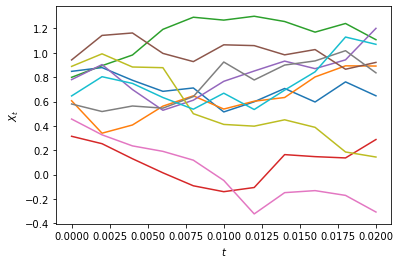

In [6]:
num_sample=10

# Draw 10 sample paths
X,dW = draw_X_and_dW(num_sample, np.random.rand(num_sample,1),10)

# Plot these paths
fig,ax = plt.subplots(1)
for i in range(num_sample):
    ax.plot(np.linspace(0, T/N, 10 + 1),X[i,0,:])
ax.set_xlabel('$t$')
ax.set_ylabel('$X_t$');

In [7]:
def simulate_Y_once(current_step, inp, model, fun_fr, fun_fi, fun_dgr, fun_dgi):

    # Check the input current_step, we need it to be within 0 to N-1.
    if not (0 <= current_step <= N-1):
        raise ValueError(f"current step must be between 0 and N-1")

    X, dW = inp
    num_sample = X.shape[0]
    e_num_sample = tf.ones(shape=[num_sample, 1], dtype=DTYPE)
    # y approximation now
    yr_now = e_num_sample * model.yr[current_step](X[:,:,0])
    yi_now = e_num_sample * model.yi[current_step](X[:,:,0])

    # z approximation now
    zr_now = e_num_sample * model.zr[current_step](X[:,:,0])
    zi_now = e_num_sample * model.zi[current_step](X[:,:,0])    

    for i in range(current_step,current_step+1):
        # Now we get the current_step+1 value bacause of the Stratonovich integral 
        if i == N-1:
            zr_next = fun_dgr(X[:, :, i-current_step+1])
            zi_next = fun_dgi(X[:, :, i-current_step+1])
        else:
            zr_next = model.zr[i+1](X[:, :, i-current_step+1])
            zi_next = model.zi[i+1](X[:, :, i-current_step+1])

        # Now we calculate the yr_next, yi_next
        eta1r = fun_fi(t_space[i],yr_now,yi_now) * dt
        eta2r = 0.5 * ((zr_next + zi_next) - (zr_now + zi_now)) * dW[:, :, i-current_step] + zr_now*dW[: , :, i-current_step]
        eta1i = -fun_fr(t_space[i],yr_now,yi_now) * dt 
        eta2i = -0.5 * ((zr_next - zi_next) - (zr_now - zi_now)) * dW[:, :, i-current_step] + zi_now*dW[:, :, i-current_step]

        # Compute new value approximations at t_{i+1}
        yr_now = yr_now + eta1r + eta2r
        yi_now = yi_now + eta1i + eta2i

    return yr_now,yi_now

In [8]:
def loss_fn_till_end(current_step, inp, model, fun_fr, fun_fi, fun_gr, fun_gi, fun_dgr, fun_dgi):

    # Check the input current_step, we need it to be within 0 to N-1.
    if not (0 <= current_step <= N-1):
        raise ValueError(f"current step must be between 0 and N-1")
    
    X, _ = inp

    # Forward pass to compute value estimates
    yr_pred,yi_pred = simulate_Y_once(current_step, inp, model, fun_fr,fun_fi,fun_dgr, fun_dgi)

    # Final time condition
    if current_step == N-1:
        yr_true = fun_gr(X[:, :, 1])
        yi_true = fun_gi(X[:, :, 1])
        zr_true = fun_dgr(X[:, :, 1])
        zi_true = fun_dgi(X[:, :, 1])
    else:
        yr_true = model.yr[current_step+1](X[:,:,1])
        yi_true = model.yi[current_step+1](X[:,:,1])
        zr_true = model.zr[current_step+1](X[:, :, 1])
        zi_true = model.zi[current_step+1](X[:, :, 1])
    
# Compute mean squared error
    yr_diff = yr_true - yr_pred
    yi_diff = yi_true - yi_pred
    loss = tf.reduce_mean(tf.square(yr_diff) + tf.square(yi_diff))

    return loss

In [9]:
# Define cost function fr fi
def fun_fi(t, yr, yi):
    return  0.0
def fun_fr(t, yr, yi):
    return  0.0

# Set terminal value function g
def fun_gr(x):
    return tf.math.cos(tf.math.sqrt(2.)*x)
def fun_gi(x):
    return tf.math.sin(tf.math.sqrt(2.)*x)

def fun_dgr(x):
    return -tf.math.sqrt(2.)*tf.math.sin(tf.math.sqrt(2.)*x)
def fun_dgi(x):
    return tf.math.sqrt(2.)*tf.math.cos(tf.math.sqrt(2.)*x)
# Set learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([100,1000],[1e-2,.8e-2,.5e-2])
#lr = 1e-2
# Choose optimizer for gradient descent step
optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8)

# Initialize neural network architecture
model = BSDEModel()
history = []

In [10]:
@tf.function
def compute_grad(current_step, inp, model, fun_fr, fun_fi, fun_gr, fun_gi, fun_dgr, fun_dgi):
    current_step_trainable_variables = model.yr[current_step].trainable_variables+model.yi[current_step].trainable_variables+model.zr[current_step].trainable_variables+model.zi[current_step].trainable_variables
    with tf.GradientTape() as tape:
        loss = loss_fn_till_end(current_step, inp, model, fun_fr,fun_fi, fun_gr, fun_gi,fun_dgr, fun_dgi)
    
    grad = tape.gradient(loss, current_step_trainable_variables)
    return loss, grad

In [11]:
t0 = time()
batch_size = 4096
random_pts = 1024
num_epochs_terminal = 31
num_epochs_general = 31
save_point = 30
#we require these two epoch numbers to be equal and of the form xx1.

In [12]:
#this section of code is for save/load the program
import os
import re

def find_largest_epoch_and_smallest_step(directory):
    # Regular expression to match the required filename pattern
    pattern = re.compile(r'step_(\d+)_num_epochs_(\d+)')
    
    # Variables to keep track of the smallest step and largest epoch for that step
    min_step = float('inf')
    max_epoch = 0
    found = False
    
    # Loop over each file in the directory
    for filename in os.listdir(directory):
        match = pattern.search(filename)
        if match:
            step = int(match.group(1))
            epoch = int(match.group(2))
            
            # Check if this file has a smaller step or if it matches the current smallest step
            if step < min_step:
                min_step = step
                max_epoch = epoch
                found = True
            elif step == min_step:
                max_epoch = max(max_epoch, epoch)
    
    # Return the result based on whether we found any matching files
    if found:
        return max_epoch, min_step
    else:
        return 0, N-1

current_directory = os.getcwd()
now_epoch_step = find_largest_epoch_and_smallest_step(current_directory)
print(now_epoch_step)

(0, 24)


In [13]:
#this section of code is for save/load the program
if not(now_epoch_step[0] == 0 and now_epoch_step[1] == N-1):
    for current_step in range(now_epoch_step[1]+1,N):
        # Create an array of x values from -2π to 2π
        model.yr[current_step].load_weights(f'yr_current_step_{current_step}_num_epochs_{num_epochs_terminal-1}.h5')
        model.yi[current_step].load_weights(f'yi_current_step_{current_step}_num_epochs_{num_epochs_terminal-1}.h5')
        model.zr[current_step].load_weights(f'zr_current_step_{current_step}_num_epochs_{num_epochs_terminal-1}.h5')
        model.zi[current_step].load_weights(f'zi_current_step_{current_step}_num_epochs_{num_epochs_terminal-1}.h5')
    current_step = now_epoch_step[1]
    model.yr[current_step].load_weights(f'yr_current_step_{current_step}_num_epochs_{now_epoch_step[0]}.h5')
    model.yi[current_step].load_weights(f'yi_current_step_{current_step}_num_epochs_{now_epoch_step[0]}.h5')
    model.zr[current_step].load_weights(f'zr_current_step_{current_step}_num_epochs_{now_epoch_step[0]}.h5')
    model.zi[current_step].load_weights(f'zi_current_step_{current_step}_num_epochs_{now_epoch_step[0]}.h5')


Step      Iter      Loss        x|  Time    Stepsize
   24     0       1.0410   0.2235 |    3.2  4.00e-02
   24     0       1.0148   2.7840 |    3.2  4.00e-02
   24     0       1.0015  -1.0034 |    3.2  4.00e-02
   24     0       0.9916   2.3925 |    3.2  4.00e-02
   24     0       1.0007   2.2835 |    3.2  4.00e-02
   24     0       0.9935   3.1452 |    3.3  4.00e-02
   24     0       0.9968  -2.6736 |    3.3  4.00e-02
   24     0       0.9867   0.4751 |    3.3  4.00e-02
   24     0       1.0017  -1.9942 |    3.3  4.00e-02
   24     0       0.9975  -0.2760 |    3.3  4.00e-02
   24     0       0.9917  -4.7455 |    3.3  4.00e-02
   24     0       0.9830   1.0277 |    3.3  4.00e-02
   24     0       0.9888  -0.0837 |    3.4  4.00e-02
   24     0       0.9882  -2.9784 |    3.4  4.00e-02
   24     0       0.9851   3.2132 |    3.4  4.00e-02
   24     0       0.9893   0.5789 |    3.4  4.00e-02
   24     0       0.9886   4.9015 |    3.4  4.00e-02
   24     0       0.9873  -4.5181 |    3.4  4.

KeyboardInterrupt: 

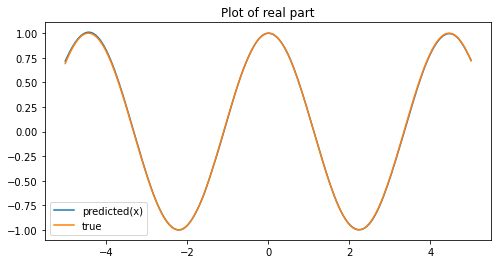

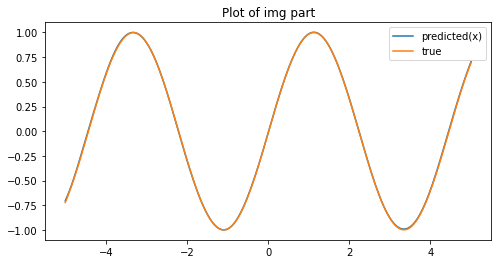

In [14]:
#Now we start the training
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([100,1000],[4e-2,1e-2,.5e-2])

#Initialize header of output
print('Step      Iter      Loss        x|  Time    Stepsize')

for current_step in reversed(range(now_epoch_step[1]+1)):
    if current_step == N-1:
        num_epochs = num_epochs_terminal
    else:
        num_epochs = num_epochs_general
    if current_step == now_epoch_step[1]:
        for i in range(now_epoch_step[0],num_epochs):
            for _ in range(random_pts):
                x = (np.random.rand(batch_size,1)-1/2)*10
                # Each epoch we draw a batch of batch_size random paths
                X, dW = draw_X_and_dW(batch_size, x, N-current_step)
                # Compute the loss as well as the gradient
                loss, grad = compute_grad(current_step,(X, dW), model, fun_fr,fun_fi, fun_gr,fun_gi,fun_dgr, fun_dgi)
                current_step_trainable_variables = model.yr[current_step].trainable_variables+model.yi[current_step].trainable_variables+model.zr[current_step].trainable_variables+model.zi[current_step].trainable_variables
                optimizer.apply_gradients(zip(grad, current_step_trainable_variables))

                # Get current Y_0 \approx u(0,x)
                yr = model.yr[current_step](x)
                yi = model.yi[current_step](x)
                yr = yr.numpy()[0,0]
                yi = yi.numpy()[0,0]

                currtime = time() - t0
                hentry = (current_step, i, loss.numpy(), x[0,0], currtime, lr(i))
                history.append(hentry)
                if i%save_point == 0:
                        print('{:5d} {:5d} {:12.4f} {:8.4f} | {:6.1f}  {:6.2e}'.format(*hentry))        
            if i%save_point == 0:
                print('Step      Iter      Loss        x|  Time    Stepsize')
            if i%save_point == 0:
                model.yr[current_step].save_weights(f'yr_current_step_{current_step}_num_epochs_{i}.h5')
                model.yi[current_step].save_weights(f'yi_current_step_{current_step}_num_epochs_{i}.h5')
                model.zr[current_step].save_weights(f'zr_current_step_{current_step}_num_epochs_{i}.h5')
                model.zi[current_step].save_weights(f'zi_current_step_{current_step}_num_epochs_{i}.h5')
        #plot real part graph:
        x = np.linspace(x_low_bd, x_up_bd, 200)
        x = x.reshape(200,1)
        # Compute the sine of each x value
        y = model.yr[current_step](x)
        j = np.cos(np.sqrt(2)*x-(N-current_step)*T/N)

        # Create the plot
        plt.figure(figsize=(8, 4))  # Set the figure size
        plt.plot(x, y, label='predicted(x)')  # Plot x against sin(x)
        plt.plot(x, j, label='true') 

        # Add a title and labels
        plt.title('Plot of real part')

        # Add a legend
        plt.legend()

        # Show the plot
        current_time = datetime.datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"plot_T_{T}_N_{N}_neuron_{neuron}_real_{formatted_time}_step_{current_step}_yz.png"
        plt.savefig(filename)
        print(f"Plot saved as {filename}")

        #plot img part graph:
        y = model.yi[current_step](x)
        j =  np.sin(np.sqrt(2)*x-(N-current_step)*T/N)

        # Create the plot
        plt.figure(figsize=(8, 4))  # Set the figure size
        plt.plot(x, y, label='predicted(x)')  # Plot x against sin(x)
        plt.plot(x, j, label='true') 

        # Add a title and labels
        plt.title('Plot of img part')

        # Add a legend
        plt.legend()

        # Show the plot
        current_time = datetime.datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"plot_T_{T}_N_{N}_neuron_{neuron}_img_{formatted_time}_step_{current_step}_yz.png"
        plt.savefig(filename)
        print(f"Plot saved as {filename}")
        
    else:
        for i in range(num_epochs):
            for _ in range(random_pts):
                x = (np.random.rand(batch_size,1)-1/2)*10
                # Each epoch we draw a batch of batch_size random paths
                X, dW = draw_X_and_dW(batch_size, x, N-current_step)
                # Compute the loss as well as the gradient
                loss, grad = compute_grad(current_step,(X, dW), model, fun_fr,fun_fi, fun_gr,fun_gi,fun_dgr, fun_dgi)
                current_step_trainable_variables = model.yr[current_step].trainable_variables+model.yi[current_step].trainable_variables+model.zr[current_step].trainable_variables+model.zi[current_step].trainable_variables
                optimizer.apply_gradients(zip(grad, current_step_trainable_variables))

                # Get current Y_0 \approx u(0,x)
                yr = model.yr[current_step](x)
                yi = model.yi[current_step](x)
                yr = yr.numpy()[0,0]
                yi = yi.numpy()[0,0]

                currtime = time() - t0
                hentry = (current_step, i, loss.numpy(), x[0,0],currtime, lr(i))
                history.append(hentry)
                if i%save_point == 0:
                        print('{:5d} {:5d} {:12.4f} {:8.4f}| {:6.1f}  {:6.2e}'.format(*hentry))        
            if i%save_point == 0:
                print('Step      Iter      Loss        x|  Time    Stepsize')
            if i%save_point == 0:
                model.yr[current_step].save_weights(f'yr_current_step_{current_step}_num_epochs_{i}.h5')
                model.yi[current_step].save_weights(f'yi_current_step_{current_step}_num_epochs_{i}.h5')
                model.zr[current_step].save_weights(f'zr_current_step_{current_step}_num_epochs_{i}.h5')
                model.zi[current_step].save_weights(f'zi_current_step_{current_step}_num_epochs_{i}.h5')
        #plot real part graph:
        x = np.linspace(x_low_bd, x_up_bd, 200)
        x = x.reshape(200,1)
        # Compute the sine of each x value
        y = model.yr[current_step](x)
        j = np.cos(np.sqrt(2)*x-(N-current_step)*T/N)

        # Create the plot
        plt.figure(figsize=(8, 4))  # Set the figure size
        plt.plot(x, y, label='predicted(x)')  # Plot x against sin(x)
        plt.plot(x, j, label='true') 

        # Add a title and labels
        plt.title('Plot of real part')

        # Add a legend
        plt.legend()

        # Show the plot
        current_time = datetime.datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"plot_T_{T}_N_{N}_neuron_{neuron}_real_{formatted_time}_step_{current_step}_yz.png"
        plt.savefig(filename)
        print(f"Plot saved as {filename}")

        #plot img part graph:
        y = model.yi[current_step](x)
        j = np.sin(np.sqrt(2)*x-(N-current_step)*T/N)

        # Create the plot
        plt.figure(figsize=(8, 4))  # Set the figure size
        plt.plot(x, y, label='predicted(x)')  # Plot x against sin(x)
        plt.plot(x, j, label='true') 

        # Add a title and labels
        plt.title('Plot of img part')

        # Add a legend
        plt.legend()

        # Show the plot
        current_time = datetime.datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"plot_T_{T}_N_{N}_neuron_{neuron}_img_{formatted_time}_step_{current_step}_yz.png"
        plt.savefig(filename)
        print(f"Plot saved as {filename}")
        